In [2]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)

In [3]:
torch.manual_seed(42)
df_train=pd.read_parquet("df_train_cleaned.parquet")

In [4]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

NameError: name 'record_path' is not defined

In [64]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.Grayscale(),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness=0.1, contrast=0.1),
])


# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True)

In [79]:
import torch.nn as nn
import torch.nn.functional as F

class XrayCNN(nn.Module):
    def __init__(self, num_classes):
        super(XrayCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # (16, 224, 224)
        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dimensions

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # (32, 112, 112)
        self.pool2 = nn.MaxPool2d(2, 2)  # Halves spatial dimensions again

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (64, 56, 56)
        self.pool3 = nn.MaxPool2d(2, 2)  # Halves spatial dimensions again

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # (128, 28, 28)
        self.pool4 = nn.MaxPool2d(2, 2)  # (128, 14, 14)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # (256, 14, 14)
        self.pool5 = nn.MaxPool2d(2, 2)  # (256, 7, 7)

        # Fully Connected layers (much smaller!)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [80]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
num_classes = 8 # Assuming each column (except 'Image Index') is a class
model = XrayCNN(num_classes).to(device)

In [81]:


# Loss function and optimizer
pos_weight = (df_train.iloc[:,1:]==0.).sum()/df_train.iloc[:,1:].sum()
class_weights=torch.tensor(pos_weight.values,dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
# Create the trainer and evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "precision": Precision(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "recall": Recall(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

# Validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

In [82]:
trainer.run(train_loader, max_epochs=100)

[1/4005]   0%|           [00:00<?]

Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [34]:
train_loader

In [ ]:
df_test=pd.read_parquet("df_test_cleaned.parquet")

,Image Index,Mass,Atelectasis,Pleural_Thickening,Consolidation,Infiltration,Pneumothorax,Nodule,Effusion
38,00000013_000.png,0,0,0,0,0,0,0,0
39,00000013_001.png,0,0,0,0,0,1,0,0
40,00000013_002.png,0,0,0,0,0,1,0,0
41,00000013_003.png,0,0,1,0,0,0,0,0
42,00000013_004.png,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,0,0,0,0,0,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0


In [70]:
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label  = label.to(device)
        outputs = model(images)

        # Store predictions & labels
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())

    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

State:
	iteration: 767
	epoch: 1
	epoch_length: 767
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>


Classification Report (Per-Class):
              precision    recall  f1-score   support

     Class 0       0.07      0.76      0.14      1667
     Class 1       0.15      0.70      0.25      3150
     Class 2       0.05      0.79      0.09      1060
     Class 3       0.09      0.87      0.16      1724
     Class 4       0.27      0.86      0.41      5759
     Class 5       0.13      0.78      0.22      2590
     Class 6       0.07      0.68      0.13      1544
     Class 7       0.23      0.83      0.36      4501

   micro avg       0.13      0.80      0.23     21995
   macro avg       0.13      0.78      0.22     21995
weighted avg       0.17      0.80      0.28     21995
 samples avg       0.13      0.44      0.18     21995


Confusion Matrix:
 [[8978 1954  158  340   83  138  762    0]
 [2150  564   19   70    6   13   81    0]
 [ 596   81   14   10    4    2   29    0]
 [ 785  217    6   41    3    4   19    0]
 [2810  765   32  129   18   21  100    0]
 [1270  128   13   35   

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


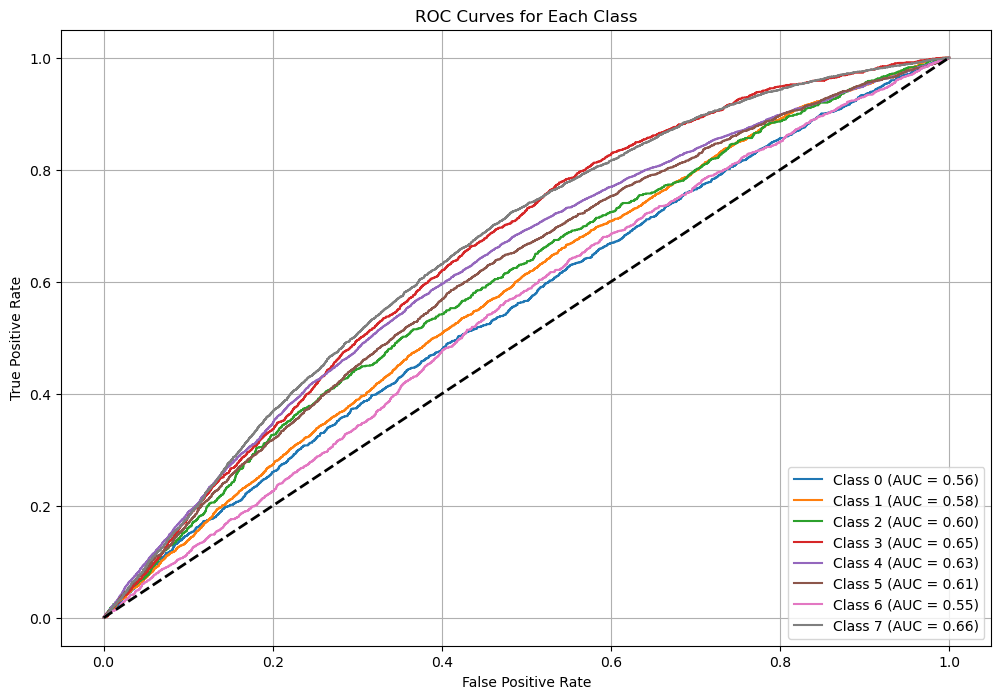

In [71]:
# Convert lists to arrays
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
preds = (probs > 0.5).astype(int)

# %% [markdown]
# ## Metrics on Test Set

y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[f"Class {i}" for i in range(y_true.shape[1])]
    )
)

# Confusion matrix (argmax at the row level can be misleading for multi-label,
# but shown here for demonstration.)
cm = confusion_matrix(
    y_true.argmax(axis=1), 
    y_pred.argmax(axis=1)
)
print("\nConfusion Matrix:\n", cm)

# Element-wise binary accuracy
correct_predictions = (y_true == y_pred).sum()
total_predictions   = y_true.size
binary_accuracy     = correct_predictions / total_predictions
print(f"Binary Accuracy: {binary_accuracy:.4f}")

# %% [markdown]
# ## ROC Curves (Optional)

plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [73]:
cnn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [74]:
cnn_params

51386184